In [1]:
# This is to find the current price of particular stock
import yfinance as yf

# Define the stock ticker
ticker = 'ITC.NS'

# Fetch the latest data
stock = yf.Ticker(ticker)
current_price = stock.history(period='1d')['Close'].iloc[-1]

print(f"Current stock price of {ticker}: {current_price:.2f}")

Current stock price of ITC.NS: 409.75


[*********************100%***********************]  1 of 1 completed


Data columns: MultiIndex([('Adj Close', 'ITC.NS'),
            (    'Close', 'ITC.NS'),
            (     'High', 'ITC.NS'),
            (      'Low', 'ITC.NS'),
            (     'Open', 'ITC.NS'),
            (   'Volume', 'ITC.NS')],
           names=['Price', 'Ticker'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 2.2627 - mape: 121.5597 - val_loss: 0.1286 - val_mape: 311.9684 - learning_rate: 0.0010
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0803 - mape: 76.8384 - val_loss: 0.0328 - val_mape: 370.9351 - learning_rate: 0.0010
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0163 - mape: 54.3940 - val_loss: 0.0140 - val_mape: 223.5415 - learning_rate: 0.0010
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0134 - mape: 134.4961 - val_loss: 0.0085 - val_mape: 232.2638 - learning_rate: 0.0010
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0115 - mape: 69.3644 - val_loss: 0.0222 - val_mape: 205.9532 - learning_rate: 0.0010
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0082 - mape: 66.1229 - val_loss: 0.0193 - val_mape: 232.2093 - learning_rate: 0.0010
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0073 - mape: 67.4788 - val_loss: 0.0204 - val_mape: 246.9926 

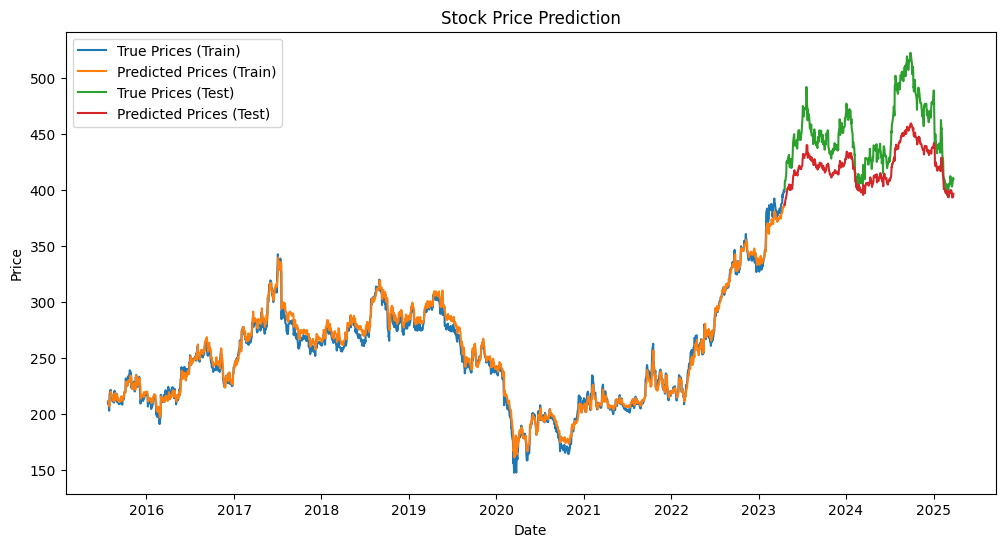

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Step 1: Fetch data from Yahoo Finance
def fetch_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    print("Data columns:", data.columns)  # Debug: Check column structure
    return data

# Step 2: Calculate technical indicators manually
def calculate_technical_indicators(data):
    # Ensure single-column Series for key columns
    close = data['Close'].squeeze()
    high = data['High'].squeeze()
    low = data['Low'].squeeze()
    volume = data['Volume'].squeeze()

    # Log transformation of Close price
    data['Log_Close'] = np.log(close)

    # Simple Moving Averages
    data['SMA_20'] = close.rolling(window=20).mean()
    data['SMA_50'] = close.rolling(window=50).mean()

    # Exponential Moving Average
    data['EMA_20'] = close.ewm(span=20, adjust=False).mean()

    # Relative Strength Index (RSI)
    delta = close.diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = close.ewm(span=12, adjust=False).mean()
    ema26 = close.ewm(span=26, adjust=False).mean()
    data['MACD'] = ema12 - ema26
    data['MACD_signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Average True Range (ATR)
    data['H-L'] = high - low
    data['H-PC'] = abs(high - close.shift())
    data['L-PC'] = abs(low - close.shift())
    data['TR'] = data[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    data['ATR'] = data['TR'].rolling(window=14).mean()

    # Volume Moving Average
    data['Volume_MA'] = volume.rolling(window=20).mean()

    # Bollinger Bands
    data['BB_std'] = close.rolling(window=20).std()
    data['BB_upper'] = data['SMA_20'] + (data['BB_std'] * 2)
    data['BB_lower'] = data['SMA_20'] - (data['BB_std'] * 2)

    # Stochastic Oscillator (%K) - Ensure scalar operations
    lowest_14 = low.rolling(window=14).min()
    highest_14 = high.rolling(window=14).max()
    data['Stoch_K'] = 100 * ((close - lowest_14) / (highest_14 - lowest_14))

    # Lagged Returns (1-day)
    data['Returns'] = close.pct_change()

    return data.dropna()


def prepare_data_with_tech_indicators(data, time_step=90):
    numeric_cols = ['Log_Close', 'SMA_20', 'SMA_50', 'EMA_20', 'RSI', 'MACD', 'MACD_signal',
                    'ATR', 'Volume_MA', 'BB_upper', 'BB_lower', 'Stoch_K', 'Returns']
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data[numeric_cols])

    x, y = [], []
    for i in range(len(scaled_data) - time_step - 1):
        x.append(scaled_data[i:(i + time_step), :])  # Include all features
        y.append(scaled_data[i + time_step, 0])  # Predict log close price

    return np.array(x), np.array(y), scaler


def create_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=input_shape),
        Dropout(0.3),
        LSTM(100, return_sequences=True, kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        LSTM(50, return_sequences=False),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mape'])
    return model


def predict_next_day(model, data, scaler, time_step=90):
    numeric_cols = ['Log_Close', 'SMA_20', 'SMA_50', 'EMA_20', 'RSI', 'MACD', 'MACD_signal',
                    'ATR', 'Volume_MA', 'BB_upper', 'BB_lower', 'Stoch_K', 'Returns']
    last_90_days = data[numeric_cols].iloc[-time_step:].values
    last_90_days_scaled = scaler.transform(last_90_days)
    X_test = np.array([last_90_days_scaled])
    next_day_prediction_scaled = model.predict(X_test)
    next_day_prediction = scaler.inverse_transform(
        np.concatenate((next_day_prediction_scaled, np.zeros((1, 12))), axis=1))
    return np.exp(next_day_prediction[0][0])


if __name__ == "__main__":

    ticker = 'ITC.NS'
    start_date = '2015-01-01'
    end_date = '2025-03-27'


    stock_data = fetch_data(ticker, start_date, end_date)


    stock_data = calculate_technical_indicators(stock_data)


    time_step = 90
    X, y, scaler = prepare_data_with_tech_indicators(stock_data, time_step)


    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]


    model = create_model(X_train.shape[1:])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
    model.fit(X_train, y_train, batch_size=16, epochs=30, validation_split=0.2,
              callbacks=[early_stopping, reduce_lr], verbose=1)


    next_day_price = predict_next_day(model, stock_data, scaler, time_step)
    print(f"Predicted stock price for the next day: {next_day_price:.2f}")


    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    train_predictions_rescaled = scaler.inverse_transform(
        np.concatenate((train_predictions, np.zeros((train_predictions.shape[0], 12))), axis=1))[:, 0]
    test_predictions_rescaled = scaler.inverse_transform(
        np.concatenate((test_predictions, np.zeros((test_predictions.shape[0], 12))), axis=1))[:, 0]
    y_train_rescaled = scaler.inverse_transform(
        np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], 12))), axis=1))[:, 0]
    y_test_rescaled = scaler.inverse_transform(
        np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 12))), axis=1))[:, 0]


    train_predictions_rescaled = np.exp(train_predictions_rescaled)
    test_predictions_rescaled = np.exp(test_predictions_rescaled)
    y_train_rescaled = np.exp(y_train_rescaled)
    y_test_rescaled = np.exp(y_test_rescaled)


    train_mape = np.mean(np.abs((y_train_rescaled - train_predictions_rescaled) / y_train_rescaled)) * 100
    test_mape = np.mean(np.abs((y_test_rescaled - test_predictions_rescaled) / y_test_rescaled)) * 100
    print(f"Train MAPE: {train_mape:.2f}%")
    print(f"Test MAPE: {test_mape:.2f}%")

    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index[time_step:train_size+time_step], y_train_rescaled, label='True Prices (Train)')
    plt.plot(stock_data.index[time_step:train_size+time_step], train_predictions_rescaled, label='Predicted Prices (Train)')
    plt.plot(stock_data.index[train_size+time_step:train_size+time_step+len(y_test)], y_test_rescaled, label='True Prices (Test)')
    plt.plot(stock_data.index[train_size+time_step:train_size+time_step+len(y_test)], test_predictions_rescaled, label='Predicted Prices (Test)')
    plt.title('Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()